## Libraries

In [1]:
# preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Set a style for better visuals
sns.set(style="whitegrid")
# anomaly detection
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
# time series
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
# metrics
from sklearn.metrics import mean_squared_error
# from printing & warning
import os
import warnings
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None) # Show all columns
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# Set random seeds for reproducibility
import random
import tensorflow as tf
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
# helps ensure more consistent behavior
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [3]:
import keras
print(keras.__version__)

2.15.0


## Upload data

In [4]:
# Extract the file ID from the Google Drive link
file_id = '1iqPB_vfT5fNa4HrH4wmkJaxMXaSMaqcD'

# Construct the download URL
download_url = f'https://drive.google.com/uc?id={file_id}'

# Read the CSV file directly from the URL
data1 = pd.read_csv(download_url)

# Extract the file ID from the Google Drive link
file_id2 = '1cjfQVCfIcbpyqOq6C8r-WgylTo9ku06G'

# Construct the download URL
download_url2 = f'https://drive.google.com/uc?id={file_id2}'

# Read the CSV file directly from the URL
data2 = pd.read_csv(download_url2)

# Extract the file ID from the Google Drive link
file_id3 = '1Us9WgsWGMdsncQv4d3pc4sxTMgKDd-eJ'

# Construct the download URL
download_url3 = f'https://drive.google.com/uc?id={file_id3}'

# Read the CSV file directly from the URL
data3 = pd.read_csv(download_url3)

# Concatenate the DataFrames
df = pd.concat([data1, data2, data3], ignore_index=True)

# print data
df.head()

,date,category,amount
0,2022-07-06 05:57:10 +0000,Restuarant,5.50
1,2022-07-06 05:57:27 +0000,Market,2.00
2,2022-07-06 05:58:12 +0000,Coffe,30.10
3,2022-07-06 05:58:25 +0000,Market,17.33
4,2022-07-06 05:59:00 +0000,Restuarant,5.50


In [5]:
df.shape

(12641, 3)

In [6]:
print(df.duplicated().sum())

8044


In [7]:
df = df.drop_duplicates()
print(df.shape)

(4597, 3)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4597 entries, 0 to 12640
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      4597 non-null   object 
 1   category  4597 non-null   object 
 2   amount    4597 non-null   float64
dtypes: float64(1), object(2)
memory usage: 143.7+ KB


In [9]:
# Convert the column to datetime and extract only the date to change format to YYYY-MM-DD
df["date"] = pd.to_datetime(df["date"]).dt.date
# Convert the column to 'datetime64' dtype (date-only format)
df["date"] = pd.to_datetime(df["date"])

In [10]:
df.head()

,date,category,amount
0,2022-07-06,Restuarant,5.50
1,2022-07-06,Market,2.00
2,2022-07-06,Coffe,30.10
3,2022-07-06,Market,17.33
4,2022-07-06,Restuarant,5.50


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4597 entries, 0 to 12640
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      4597 non-null   datetime64[ns]
 1   category  4597 non-null   object        
 2   amount    4597 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 143.7+ KB


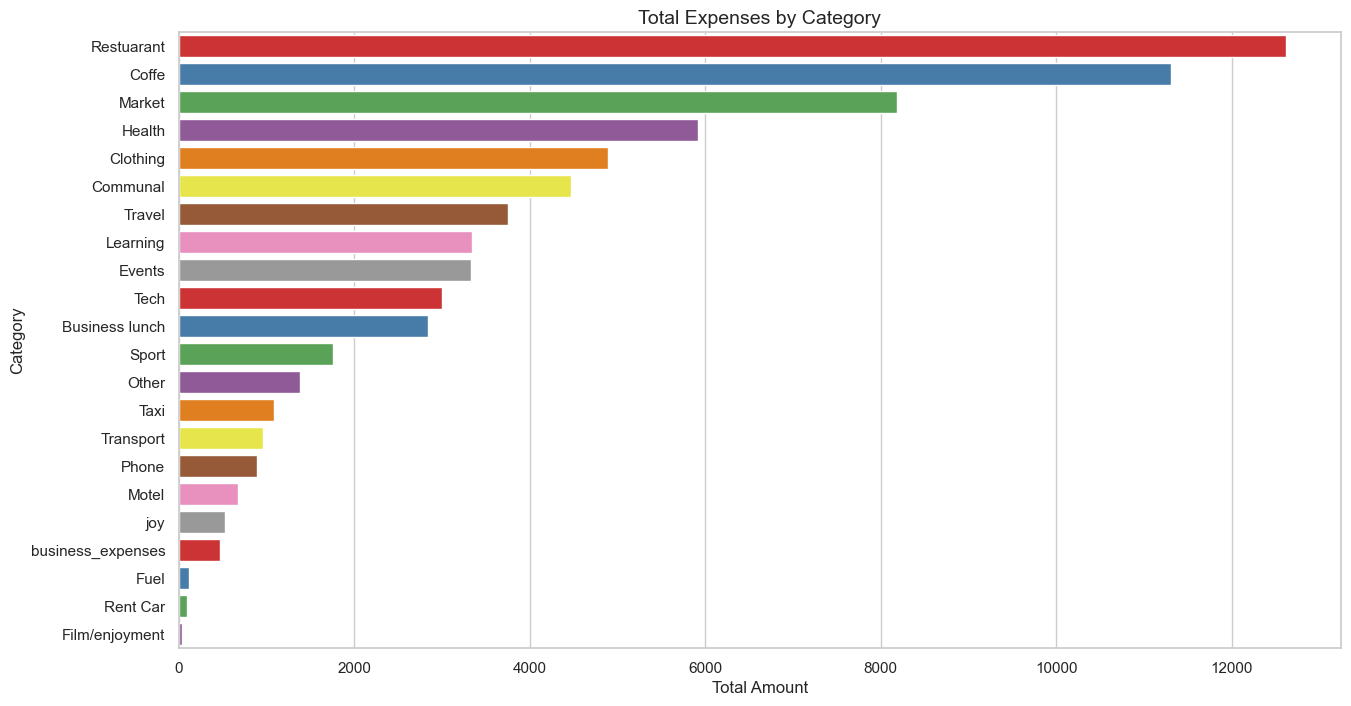

In [12]:
plt.figure(figsize=(15, 8))
category_totals = df.groupby('category')['amount'].sum().sort_values(ascending=False)

# Create a barplot with a colorful palette
sns.barplot(x=category_totals.values, y=category_totals.index, palette="Set1")

plt.title('Total Expenses by Category', fontsize=14)
plt.xlabel('Total Amount', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.show()

In [13]:
# Define category mappings
category_mapping = {
    "Food": ["Restuarant", "Coffe", "Business lunch","Market"],
    "Fashion":["Clothing"],
    "Health": ["Health"],
    "Transportation": ["Travel", "Taxi", "Transport", "Fuel","Rent Car","Motel"],
    "Entertainment": ["Events", "joy", "Film/enjoyment","Other","Phone"],
    "Education": ["business_expenses", "Tech", "Learning"],
    "Lifestyle":["Communal", "Sport"]
}
# Create a dictionary to map each subcategory to its main category
replacement_dict = {subcategory: main_category for main_category, subcategories in category_mapping.items() for subcategory in subcategories}

# Replace category values with their main category
df["category"] = df["category"].replace(replacement_dict)

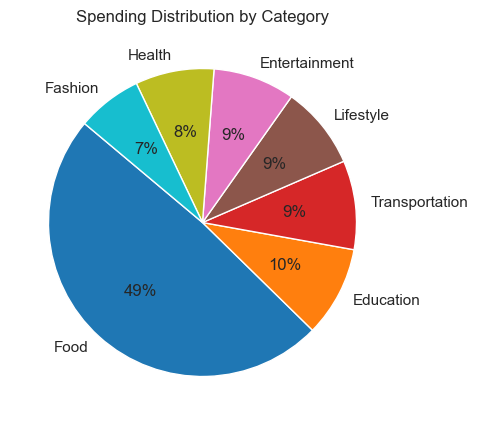

In [14]:
# Plot pie chart
category_totals = df.groupby('category')['amount'].sum().sort_values(ascending=False)

plt.figure(figsize=(5, 5))
category_totals.plot(kind='pie', autopct='%1.0f%%', startangle=140, cmap='tab10')

# Customize chart
plt.title("Spending Distribution by Category")
plt.ylabel("")  # Hide y-label for better visualization
plt.show()

In [15]:
# Pivot table to sum amounts per category per date
daily_data = df.pivot_table(index="date", columns="category", values="amount", aggfunc="sum").fillna(0)

# Dynamically sum all expense categories (excluding potential non-expense categories like "Income")
daily_data["Expenses"] = daily_data.sum(axis=1)

# Display the result
daily_data.head()

category,Education,Entertainment,Fashion,Food,Health,Lifestyle,Transportation,Expenses
date,,,,,,,,
2022-07-06,0.0,0.0,0.0,124.38,0.0,0.0,5.0,129.38
2022-07-07,0.0,0.0,0.0,20.73,0.0,0.0,0.0,20.73
2022-07-08,0.0,0.0,0.0,21.02,0.0,0.0,0.0,21.02
2022-07-09,0.0,0.0,0.0,53.70,0.0,0.0,5.0,58.70
2022-07-10,0.0,30.0,0.0,0.00,0.0,0.0,21.0,51.00


In [16]:
# Calculate the time difference between consecutive data points
time_diff = daily_data.index.to_series().diff()

# Find the most common time difference
most_common_freq = time_diff.mode().iloc[0]

# Display the frequency of the data
print(f"Data Frequency: {most_common_freq}")

Data Frequency: 1 days 00:00:00


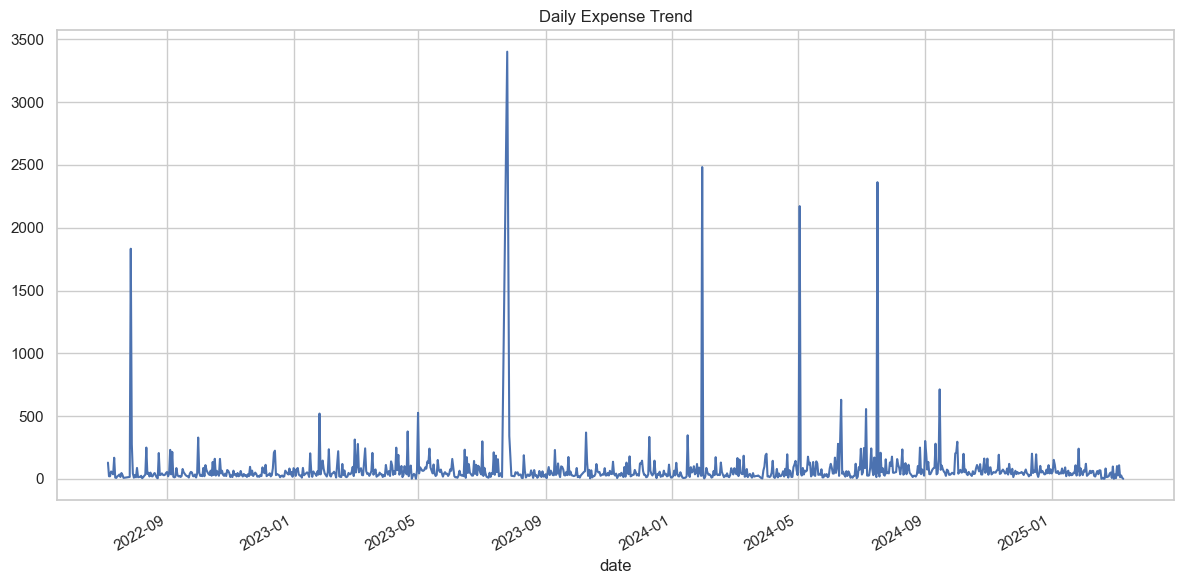

In [17]:
daily_data.Expenses.plot(title='Daily Expense Trend',figsize=(12, 6))
plt.tight_layout()
plt.show()

## Anomaly Detection
## Anomaly Detection Estimators

This section briefly describes the three estimators used for anomaly detection: **KNN**, **LOF**, and **Isolation Forest (iForest)**.

---

### 1. K-Nearest Neighbors (KNN)

- **Concept**: Detects anomalies based on the distance to *k* nearest neighbors.
- **How it works**: Data points far from their *k* nearest neighbors are likely to be outliers.
- **Strengths**:
  - Simple and intuitive.
  - Works well with well-separated clusters.
- **Limitations**:
  - Computationally expensive on large datasets.

---

### 2. Local Outlier Factor (LOF)

- **Concept**: Measures the local density deviation of a data point compared to its neighbors.
- **How it works**: Points that have a much lower density than their neighbors are considered outliers.
- **Strengths**:
  - Captures local outliers within clusters.
- **Limitations**:
  - Sensitive to the `n_neighbors` parameter.

---

### 3. Isolation Forest (iForest)

- **Concept**: Anomalies are isolated faster because they are few and different.
- **How it works**:
  1. Builds isolation trees by randomly selecting features and split values.
  2. Calculates the average path length for each data point across trees.
  3. Points with shorter paths are considered anomalies.
- **Strengths**:
  - Scalable to large and high-dimensional datasets.
  - Efficient and fast.
- **Limitations**:
  - Performance may degrade with very small datasets.

---

In [18]:
def detect_outliers_with_ensemble(data, threshold=0.60, n_neighbors=20, random_state=42):
    """
    Detect outliers in a dataset using an ensemble of KNN, LOF, and Isolation Forest.

    Parameters:
    - data: pd.DataFrame or np.ndarray
        The input dataset with samples as rows.
    - threshold: float (default=0.65)
        The probability threshold above which a point is considered an outlier.
    - n_neighbors: int (default=20)
        Number of neighbors to use for KNN and LOF.
    - random_state: int (default=42)
        Random seed for Isolation Forest.

    Returns:
    - outliers: pd.DataFrame or np.ndarray
        The subset of data detected as outliers.
    - is_outlier: np.ndarray (bool)
        Boolean mask indicating which rows are outliers.
    - mean_scores: np.ndarray
        Averaged anomaly scores across all estimators.
    """

    # Create the ensemble of estimators
    estimators = [
        KNN(n_neighbors=n_neighbors),
        LOF(n_neighbors=n_neighbors),
        IForest(n_jobs=-1, random_state=random_state)
    ]

    # Prepare the scores array
    probability_scores = np.empty((len(data), len(estimators)))

    # Fit each model and collect probability scores
    for index, est in enumerate(estimators):
        est.fit(data)
        probs = est.predict_proba(data)
        probability_scores[:, index] = probs[:, 1]  # Use outlier probability

    # Compute mean score
    mean_scores = np.mean(probability_scores, axis=1)

    # Create mask of outliers
    is_outlier = mean_scores > threshold

    # Get outliers
    outliers = data[is_outlier]

    return outliers, is_outlier, mean_scores

In [19]:
outliers, mask, scores = detect_outliers_with_ensemble(daily_data)
print(f"Number of outliers detected: {len(outliers)}")

Number of outliers detected: 5


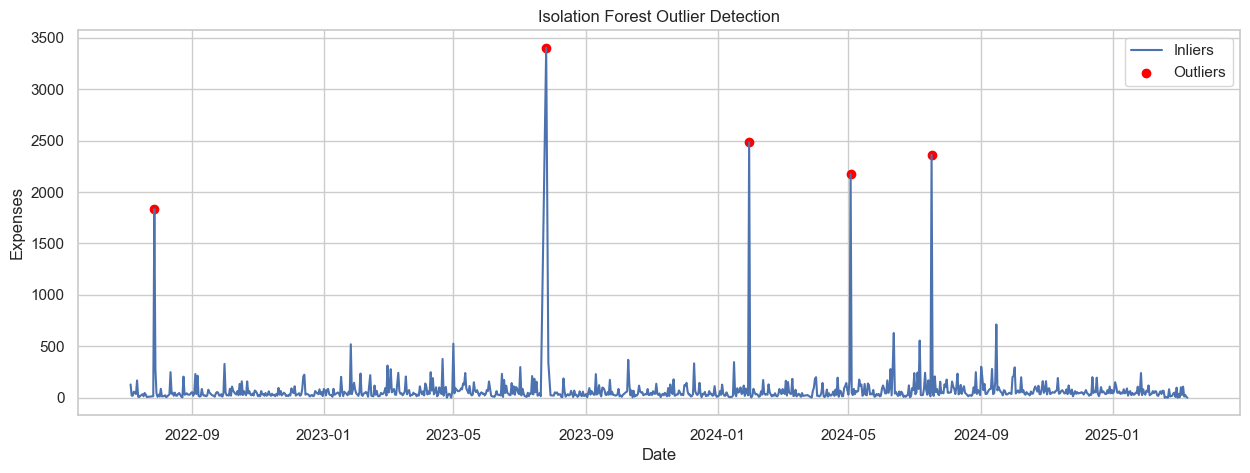

In [20]:
# Plot the data and mark outliers in red
plt.figure(figsize=(15, 5))

# Plot inliers as a line plot
plt.plot(daily_data.index, daily_data['Expenses'], label='Inliers')

# Scatter plot for outliers in red
# Use outliers.index directly and select 'Expenses' column
plt.scatter(outliers.index, outliers['Expenses'], color='red', label='Outliers')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Expenses')
plt.title('Isolation Forest Outlier Detection')
plt.legend()

# Show the plot
plt.show()

In [21]:
def remove_outliers(df_series, outliers):
    """
    Removes rows from df_series that are identified as outliers.

    Parameters:
    - df_series: The pandas DataFrame containing the data.
    - outliers: A DataFrame or Series containing the indices of outliers.

    Returns:
    - A new DataFrame with outlier rows removed.
    """
    print(f"Removing {len(outliers)} outlier rows...")

    # Drop the rows using the indices from the outliers
    df_cleaned = df_series.drop(index=outliers.index)

    return df_cleaned

In [22]:
daily_data = remove_outliers(daily_data, outliers)
daily_data.head()

Removing 5 outlier rows...


category,Education,Entertainment,Fashion,Food,Health,Lifestyle,Transportation,Expenses
date,,,,,,,,
2022-07-06,0.0,0.0,0.0,124.38,0.0,0.0,5.0,129.38
2022-07-07,0.0,0.0,0.0,20.73,0.0,0.0,0.0,20.73
2022-07-08,0.0,0.0,0.0,21.02,0.0,0.0,0.0,21.02
2022-07-09,0.0,0.0,0.0,53.70,0.0,0.0,5.0,58.70
2022-07-10,0.0,30.0,0.0,0.00,0.0,0.0,21.0,51.00


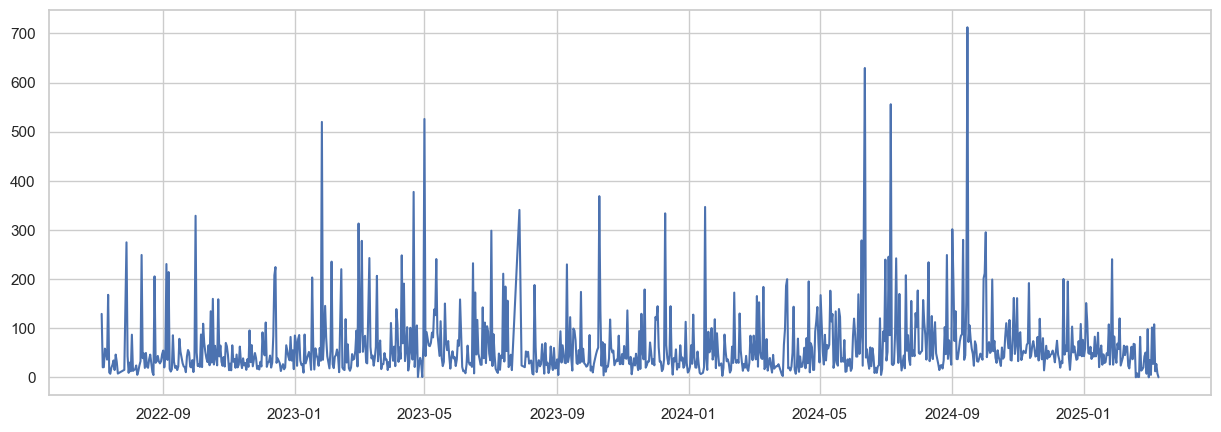

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(daily_data.index, daily_data['Expenses'])
plt.show()

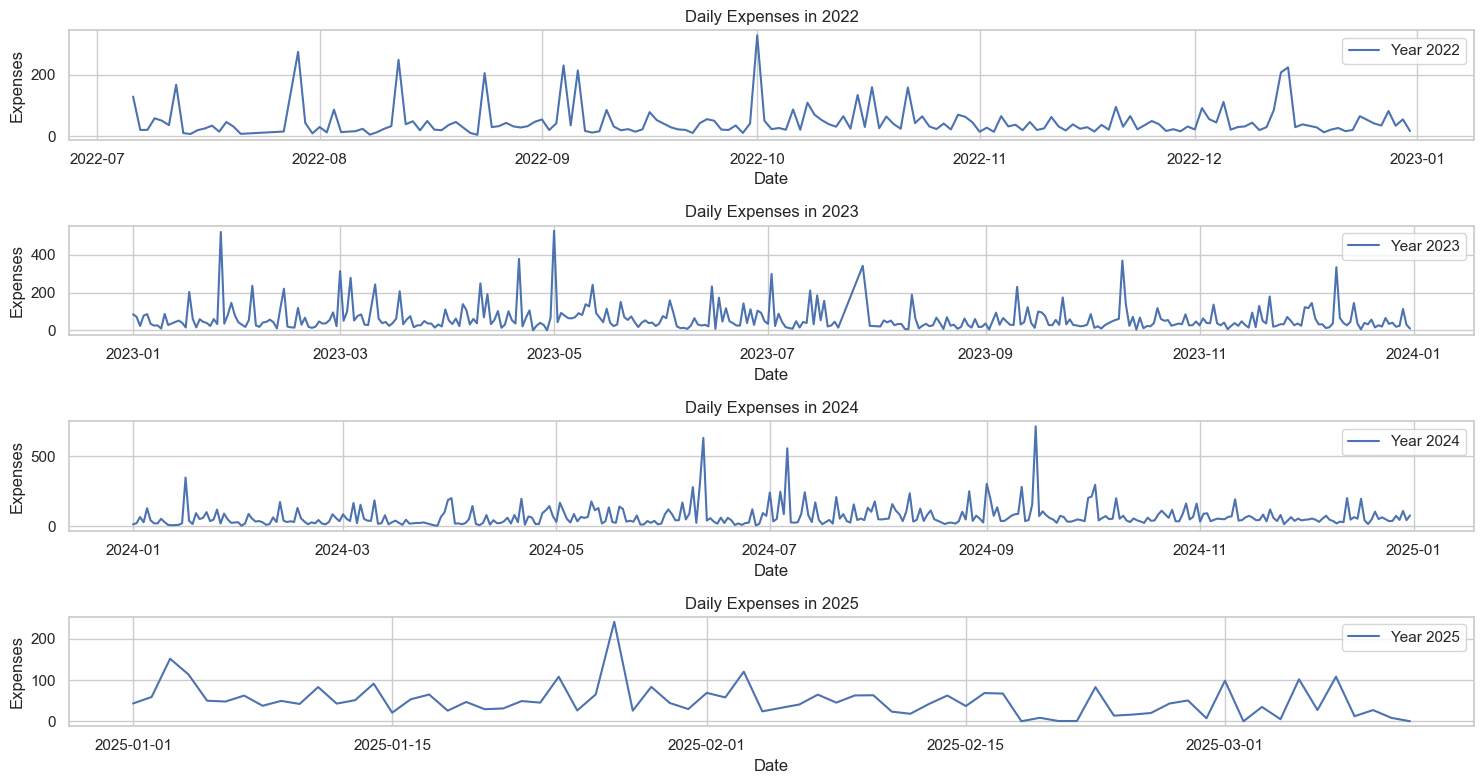

In [24]:
# Get unique years from the index (without adding a column)
years = daily_data.index.year.unique()

# Determine the number of rows and columns for subplots
n_years = len(years)
n_cols = 1  # One column of subplots
n_rows = n_years  # Number of rows will be equal to the number of years

# Create a figure with multiple subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 2 * n_years))

# If there is only one subplot, make sure it's an array for consistency
if n_years == 1:
    axes = [axes]

# Plot the data for each year in a separate subplot
for i, year in enumerate(years):
    ax = axes[i]
    year_data = daily_data[daily_data.index.year == year]
    ax.plot(year_data.index, year_data['Expenses'], label=f'Year {year}')
    ax.set_title(f'Daily Expenses in {year}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Expenses')
    ax.legend()
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [25]:
# Resample to monthly data, using the sum as the aggregation function
monthly_data = daily_data.resample('M').sum()
print(monthly_data.shape)

(33, 8)


In [26]:
# Resample to monthly data, using the sum as the aggregation function
monthly_data = daily_data.resample('M').sum()
print(monthly_data.shape)

(33, 8)


In [27]:
stl = STL(monthly_data['Expenses'], period=3, robust=True)
result = stl.fit()

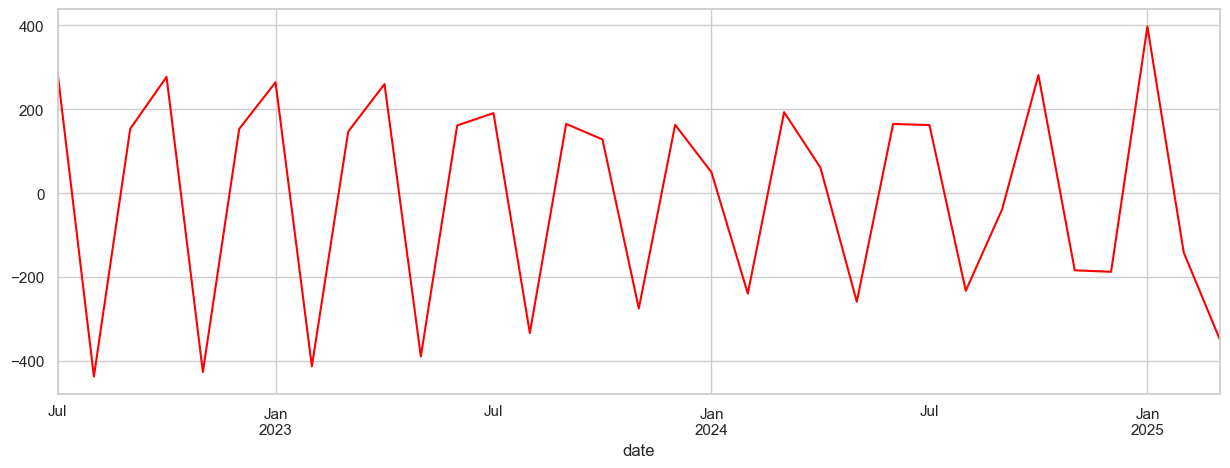

In [28]:
result.seasonal.plot(color="red", figsize=(15, 5))
plt.show()

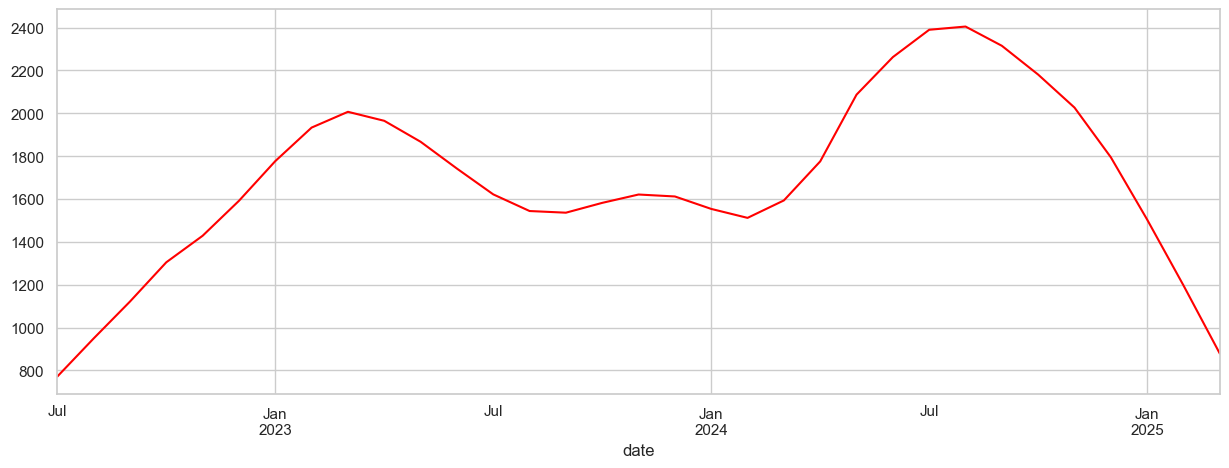

In [29]:
result.trend.plot(color="red", figsize=(15, 5))
plt.show()

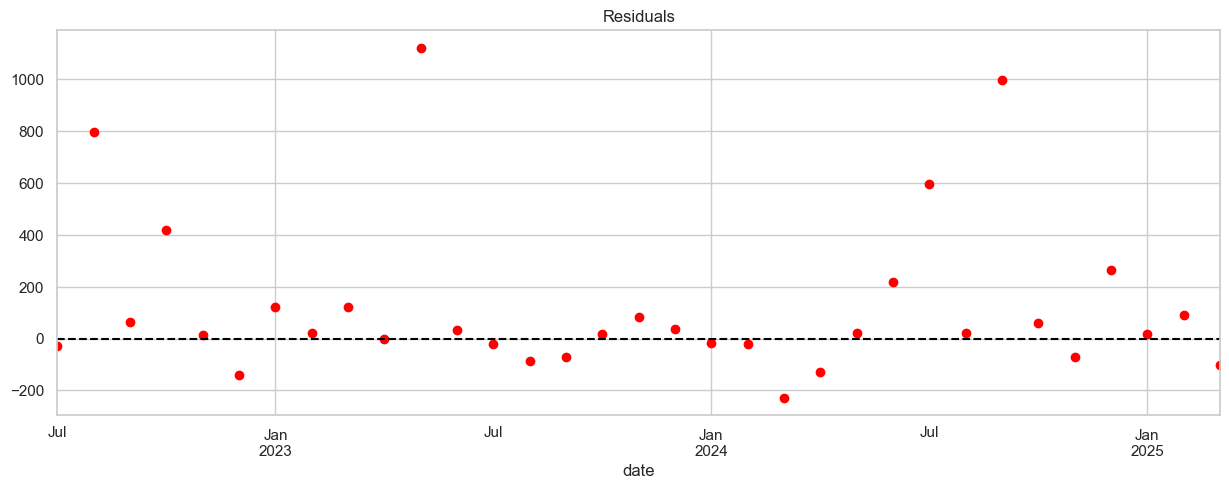

In [30]:
# Use the plot() method instead for the resid attribute
result.resid.plot(style='o', color="red", figsize=(15, 5))
plt.axhline(y=0, color='black', linestyle='--')  # Horizontal line at y=0
plt.title('Residuals')
plt.show()

In [31]:
# Removed March 2025 data point due to incomplete or missing category values,
# which could skew analysis and lead to inaccurate results.
monthly_data = monthly_data.drop(pd.to_datetime('2025-03-31'))
print(monthly_data.shape)

(32, 8)


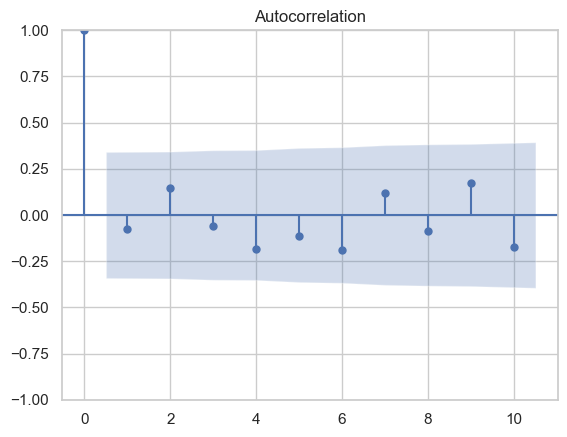

In [32]:
residuals = result.resid
plot_acf(residuals, lags=10)
plt.show()

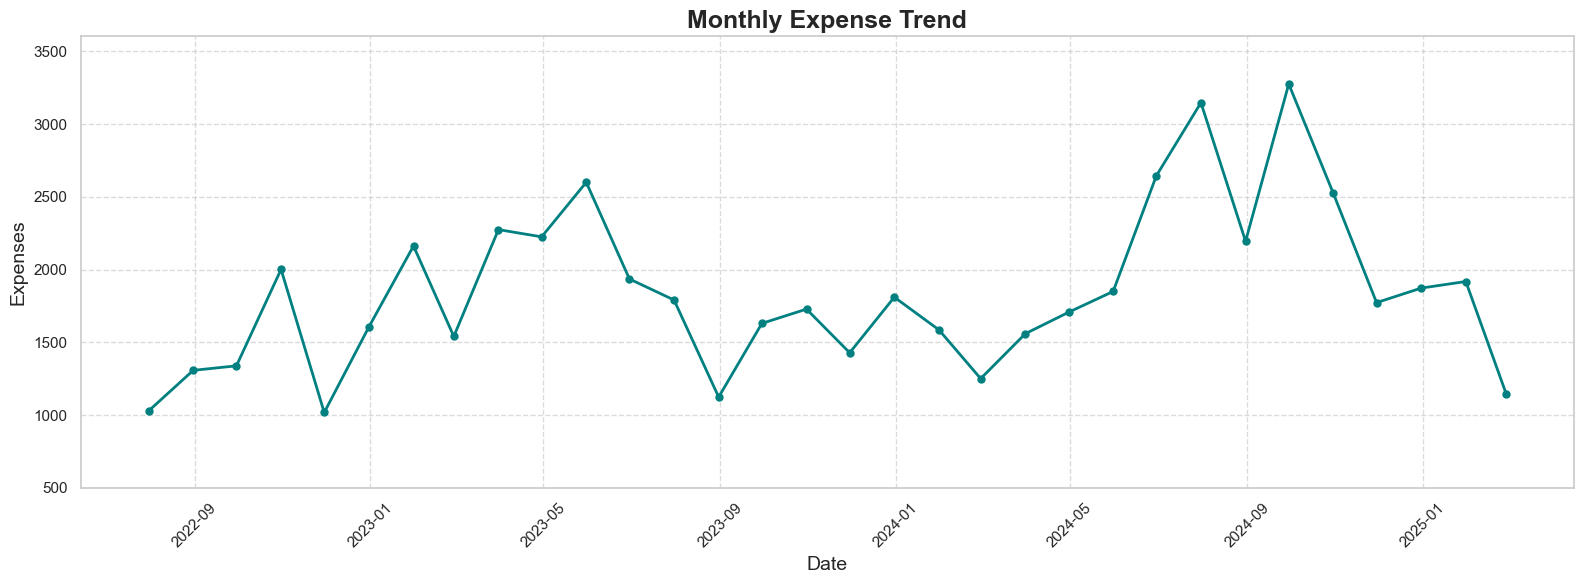

In [33]:
# Create the plot
plt.figure(figsize=(16, 6))
plt.plot(monthly_data['Expenses'], marker='o', linestyle='-', color='teal', linewidth=2, markersize=5)

# Titles and labels
plt.title('Monthly Expense Trend', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Expenses', fontsize=14)

# Improve x-axis formatting
plt.xticks(rotation=45)

# Ensure max value is fully visible with a margin
max_expense = monthly_data['Expenses'].max()
plt.ylim(500, max_expense * 1.1)  # Add 10% padding above max

# Layout and grid
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.show()

# SARIMA (Seasonal ARIMA) Model

SARIMA (Seasonal AutoRegressive Integrated Moving Average) is a classical time series forecasting model that extends ARIMA by explicitly modeling seasonality. It is well-suited for monthly data with seasonal patterns, such as your expenses dataset.

In [34]:
# Stationarity check
def check_stationarity(series):
    result = adfuller(series)
    return {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4]
    }

In [35]:
# Evaluation function
def calculate_rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

## Rolling Statistics

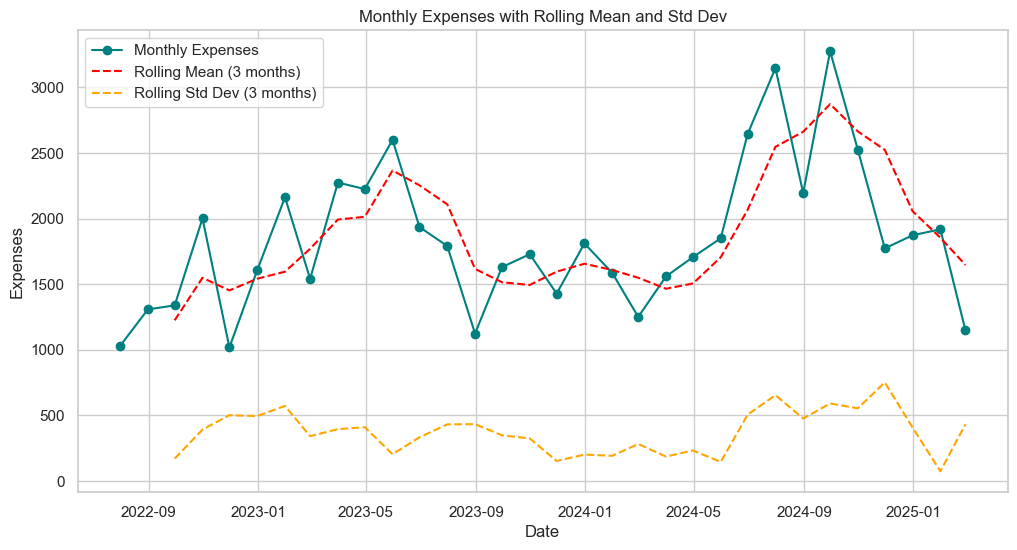

In [36]:
window_size = 3

# Calculate rolling statistics
rolling_mean = monthly_data['Expenses'].rolling(window=window_size).mean()
rolling_std = monthly_data['Expenses'].rolling(window=window_size).std()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['Expenses'], color='teal', marker='o', label='Monthly Expenses')
plt.plot(monthly_data.index, rolling_mean, color='red', linestyle='--', label=f'Rolling Mean ({window_size} months)')
plt.plot(monthly_data.index, rolling_std, color='orange', linestyle='--', label=f'Rolling Std Dev ({window_size} months)')
plt.title('Monthly Expenses with Rolling Mean and Std Dev')
plt.xlabel('Date')
plt.ylabel('Expenses')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# ADF Test
is_stationary = check_stationarity(monthly_data['Expenses'])
print("ADF Stationarity Check:")
for k, v in is_stationary.items():
    print(f"{k}: {v}")

ADF Stationarity Check:
Test Statistic: -3.257982877770966
p-value: 0.016864341790005198
Critical Values: {'1%': -3.661428725118324, '5%': -2.960525341210433, '10%': -2.6193188033298647}


<Figure size 1000x400 with 0 Axes>

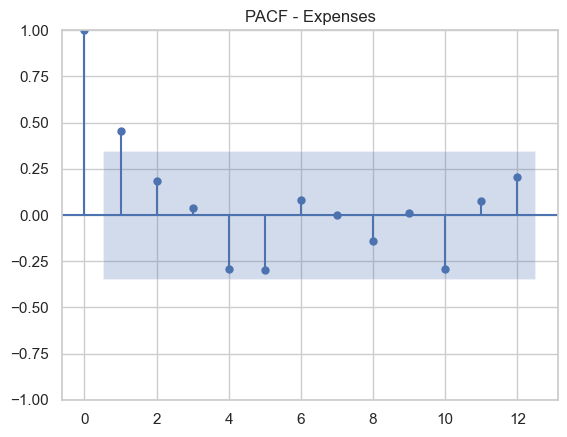

<Figure size 1000x400 with 0 Axes>

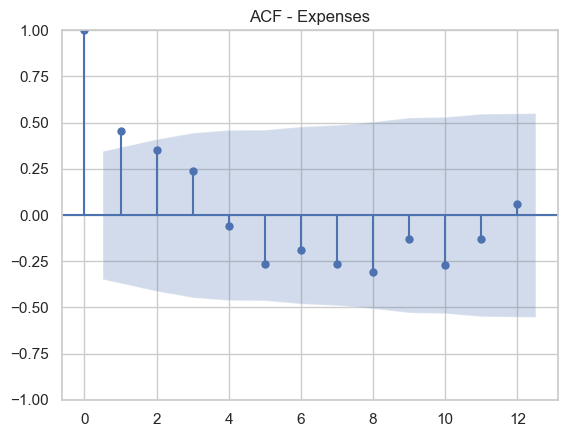

In [38]:
# ACF/PACF
plt.figure(figsize=(10, 4))
plot_pacf(monthly_data['Expenses'], lags=12, method='ywm', alpha=0.05)
plt.title("PACF - Expenses")
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(monthly_data['Expenses'], lags=12, alpha=0.05)
plt.title("ACF - Expenses")
plt.show()

In [39]:
# Create lagged exogenous variables to avoid leakage
exog_lagged = monthly_data.drop(columns=['Expenses']).shift(1)

# Train/Test Split (32 months total: 28 train, 4 test)
n_total = len(monthly_data)
n_test = 4
n_train = n_total - n_test

# Drop first row (NaN from shift)
exog_lagged = exog_lagged.dropna()

# Align endogenous and exogenous variables
endog = monthly_data['Expenses'].loc[exog_lagged.index]

train_endog = endog.iloc[:n_train-1]
test_endog = endog.iloc[n_train-1:]

train_exog = exog_lagged.iloc[:n_train-1]
test_exog = exog_lagged.iloc[n_train-1:]

# Fit SARIMAX on Training Set
p, d, q = 1, 0, 1
P, D, Q, s = 0, 0, 0, 12

model = SARIMAX(train_endog,
                exog=train_exog,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit(disp=False)

In [40]:
# Forecast next 4 months
forecast = model_fit.predict(start=test_endog.index[0],
                             end=test_endog.index[-1],
                             exog=test_exog)

# Evaluation
rmse = calculate_rmse(test_endog, forecast)
print(f"\nTest Set Evaluation (Last 4 Months):")
print(f"RMSE: {rmse:.2f}")


Test Set Evaluation (Last 4 Months):
RMSE: 840.15


# LSTM Univariate Model (Monthly data)

In [41]:
# Select the target column "Expenses" from the dataset
monthly_expenses = monthly_data.filter(["Expenses"])

# Convert the selected column to a NumPy array
dataset = monthly_expenses.values

# window size
window_size = 3

# Calculate the number of training samples (85% of the total data)
training_data_len = int(np.ceil(len(dataset) * 0.85))

# Normalize the data using StandardScaler (mean = 0, std = 1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

# Split the scaled data into training data (first 85%)
training_data = scaled_data[:training_data_len]

# Initialize empty lists for training inputs and outputs
X_train, y_train = [], []

# Create a sliding window of size 3 (look back at the past 3 months)
for i in range(window_size, len(training_data)):
    X_train.append(training_data[i-window_size:i, 0])  # last 3 values as input
    y_train.append(training_data[i, 0])      # next value as output (label)

# Convert lists to NumPy arrays for training
X_train, y_train = np.array(X_train), np.array(y_train)

In [42]:
# Build the Model
model = keras.models.Sequential()

# First Layer
model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))

# Second Layer
model.add(keras.layers.LSTM(64, return_sequences=False))

# 3rd Layer (Dense)
model.add(keras.layers.Dense(64, activation="relu"))

# 4th Layer (Dropout)
model.add(keras.layers.Dropout(0.2))

# Final Output Layer
model.add(keras.layers.Dense(1))

model.summary()
model.compile(optimizer="adam",
              loss="mae",
              metrics=[keras.metrics.RootMeanSquaredError()])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 54145 (211.50 KB)
Trainable params: 54145 (211.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



In [43]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True
)

training = model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=4,
    callbacks=[early_stop]
)

Epoch 1/1000

7/7 [==============================] - 6s 7ms/step - loss: 0.7764 - root_mean_squared_error: 1.0124
Epoch 2/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.7510 - root_mean_squared_error: 0.9861
Epoch 3/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.7242 - root_mean_squared_error: 0.9508
Epoch 4/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.7050 - root_mean_squared_error: 0.9362
Epoch 5/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.6834 - root_mean_squared_error: 0.9036
Epoch 6/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.6734 - root_mean_squared_error: 0.8848
Epoch 7/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.6492 - root_mean_squared_error: 0.8705
Epoch 8/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.6622 - root_mean_squared_error: 0.8705
Epoch 9/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.6763 - root_mean_squa

In [44]:
# Prepare the test data by selecting the remaining 10% (including the last 3 points of training for context)
test_data = scaled_data[training_data_len - window_size:]

# Initialize test input list (X_test) and true labels (y_test)
X_test, y_test = [], dataset[training_data_len:]  # y_test is in original (non-scaled) values

# Create sliding windows for test inputs (look back 3 time steps)
for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])  # past 3 values as input

# Convert test inputs to NumPy array
X_test = np.array(X_test)

# Reshape for LSTM input: (samples, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions using the trained model
predictions = model.predict(X_test)

# Reverse the scaling to get predictions in original scale
predictions = scaler.inverse_transform(predictions)

1/1 [==============================] - 1s 1s/step


In [45]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 510.90


# Multivariate input LSTM (Monthly data)
### forecast total Expenses using past category features

In [46]:
# Select feature columns (exclude "Expenses") and target column
feature_columns = ["Education", "Entertainment", "Fashion", "Food","Lifestyle", "Transportation", "Health"]
target_column = "Expenses"

window_size = 3

# Prepare features and target
features = monthly_data[feature_columns]
target = monthly_data[target_column].values

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Calculate training data length (85%)
training_data_len = int(np.ceil(len(scaled_features) * 0.85))

# Split into training and test sets
train_features = scaled_features[:training_data_len]
test_features = scaled_features[training_data_len - window_size:]  # keep 3 extra for context
train_target = target[:training_data_len]
test_target = target[training_data_len:]

# Create sliding windows for training
X_train, y_train = [], []
for i in range(window_size, len(train_features)):
    X_train.append(train_features[i-window_size:i])
    y_train.append(train_target[i])

X_train, y_train = np.array(X_train), np.array(y_train) # train shape (25, 3, 7)

In [47]:
# Build the LSTM model
model = keras.models.Sequential()
# Multivariate Input
model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(3, 7)))
model.add(keras.layers.LSTM(64, return_sequences=False))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))  # Predict single value: Expenses

# Compile the model
model.compile(optimizer="adam", loss="mae", metrics=[keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3, 64)             18432     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 55681 (217.50 KB)
Trainable params: 55681 (217.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=4,
    callbacks=[early_stop]
)

Epoch 1/1000
7/7 [==============================] - 7s 7ms/step - loss: 1944.3367 - root_mean_squared_error: 2023.5651
Epoch 2/1000
7/7 [==============================] - 0s 6ms/step - loss: 1944.2507 - root_mean_squared_error: 2023.4834
Epoch 3/1000
7/7 [==============================] - 0s 6ms/step - loss: 1944.1620 - root_mean_squared_error: 2023.3953
Epoch 4/1000
7/7 [==============================] - 0s 5ms/step - loss: 1944.0328 - root_mean_squared_error: 2023.2743
Epoch 5/1000
7/7 [==============================] - 0s 5ms/step - loss: 1943.8040 - root_mean_squared_error: 2023.0688
Epoch 6/1000
7/7 [==============================] - 0s 6ms/step - loss: 1943.4241 - root_mean_squared_error: 2022.7133
Epoch 7/1000
7/7 [==============================] - 0s 7ms/step - loss: 1942.7898 - root_mean_squared_error: 2022.0739
Epoch 8/1000
7/7 [==============================] - 0s 7ms/step - loss: 1941.3757 - root_mean_squared_error: 2020.7325
Epoch 9/1000
7/7 [==============================

In [49]:
# Prepare test set
X_test = []
for i in range(window_size, len(test_features)):
    X_test.append(test_features[i-window_size:i])  # last 3 time steps

X_test = np.array(X_test)

# Predict
predictions = model.predict(X_test)

1/1 [==============================] - 1s 849ms/step


In [50]:
# Now compute evaluation metrics in original scale
rmse = np.sqrt(mean_squared_error(test_target, predictions))

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 312.49


We used SARIMA as a traditional time series. On the test set, SARIMA achieved:
- RMSE: 953.58

LSTM model achieved the following:
- RMSE: 312.49

based on the results, LSTM clearly wins over SARIMA for this data.

In [53]:
# Save
import joblib
joblib.dump(scaler, 'model/scaler.save')
model.save('model/lstm.h5')